# 299: Exampville Simulated Data

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import larch

larch.__version__

'5.2.10'

Welcome to Exampville, the best simulated town in this here part of the internet!

Exampville is provided with Larch, and uses the
kind of data that a transportation planner might have available when building
a travel model.  However, this data is entirely fictional.

This page walks through the creation of this synthetic data.

In [2]:
np.random.seed(42)

In [3]:
import larch.exampville

## Travel Analysis Zones

We start with a shape file delineating some travel analysis zones. 
(Five bonus points if you can identify the real American city 
from which these tract shapes were derived.)

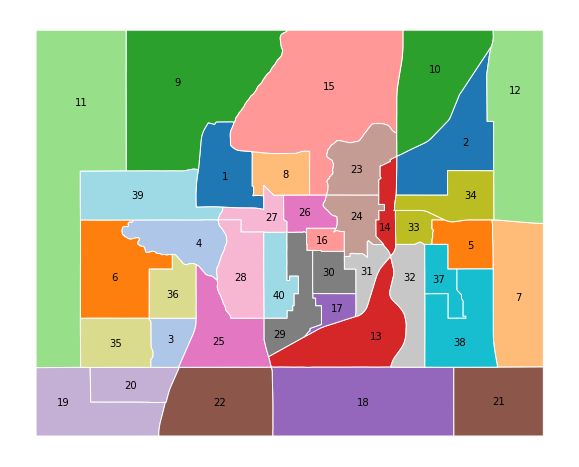

In [5]:
taz_shape = gpd.read_file("zip://"+larch.exampville.files.shapefile)
ax = taz_shape.plot(edgecolor='w', figsize=(10,10), cmap='tab20')
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

# Put Zone labels in the meatiest part of the zone shape...
for idx, row in taz_shape.iterrows():
    shrink = row['geometry']
    while True:
        try: 
            shrink1 = shrink.buffer(-5)
            if shrink1.area <= 0:
                break
            else:
                shrink = shrink1
        except:
            break
    ax.annotate(
        s=row['TAZ'], 
        xy=tuple(shrink.representative_point().coords)[0], 
        horizontalalignment='center',
        verticalalignment='center',
    )

In [6]:
nZones = len(taz_shape)

## Households

In [7]:
n_hh = 5000

In [8]:
#### Group 1: In-town density
n_hh_1 = 3500

mean = [650, 400, 11]
cov = [
    [44000,  5000, 0], 
    [ 5000, 44000, 0], 
    [    0,     0, 1],
] 

x, y, income = np.random.multivariate_normal(mean, cov, n_hh_1).T



# Assemble into a DataFrame
hh_locations = pd.DataFrame.from_dict({
    'X':np.round(x,2),
    'Y':np.round(y,2),
    'INCOME':np.exp(income).astype(int),
})

# Convert to a GeoDataFrame
hh_locations = gpd.GeoDataFrame(
    hh_locations, 
    geometry=gpd.points_from_xy(hh_locations.X, hh_locations.Y),
    crs={},
)

# Attach HOMETAZ, and drop points outside the region.
hh_locations = gpd.sjoin(hh_locations, taz_shape[['TAZ','geometry']], how='inner', op='within')

In [9]:
#### Group 2: Regional base population

n_hh_2 = n_hh - len(hh_locations) # Enough to get back to the desired total

x2 = np.random.random(n_hh_2)*1000
y2 = np.random.random(n_hh_2)*800
i2 = np.exp(np.random.random(n_hh_2)*3+8).astype(int)

# Assemble into a DataFrame
hh_locations2 = pd.DataFrame.from_dict({
    'X':np.round(x2,2),
    'Y':np.round(y2,2),
    'INCOME':i2,
})

# Convert to a GeoDataFrame
hh_locations2 = gpd.GeoDataFrame(
    hh_locations2, 
    geometry=gpd.points_from_xy(hh_locations2.X, hh_locations2.Y),
    crs={},
)

# Attach HOMETAZ
hh_locations2 = gpd.sjoin(hh_locations2, taz_shape[['TAZ','geometry']], how='inner', op='within')

In [10]:
#### Merge Groups

HH = pd.concat([hh_locations, hh_locations2])

# Clean up
HH = HH.reset_index(drop=True)
HH.rename({'TAZ':'HOMETAZ'}, axis=1, inplace=True)
HH.drop('index_right', axis=1, inplace=True)

# Add HH size and ID
HH['HHSIZE'] = np.floor(np.random.exponential(0.8, [n_hh, ]) + 1 + np.random.random([n_hh, ])).astype(int)
HH['HHID'] = HH.index + 50000

In [11]:
HH.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
X           5000 non-null float64
Y           5000 non-null float64
INCOME      5000 non-null int64
geometry    5000 non-null object
HOMETAZ     5000 non-null int64
HHSIZE      5000 non-null int64
HHID        5000 non-null int64
dtypes: float64(2), int64(4), object(1)
memory usage: 273.5+ KB


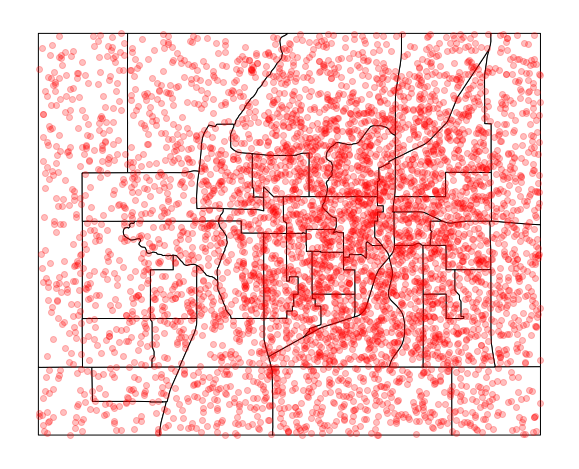

In [12]:
ax = taz_shape.plot(edgecolor='k', figsize=(10,10), color='w')
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
HH.plot(ax=ax, color='red', alpha=0.25);

In [14]:
HH.to_csv(larch.exampville.files.hh, index=False)

## People

In [15]:

HHsize = HH['HHSIZE']
n_PER = np.sum(HHsize)

PER = {}
PERidx = PER['idx'] = np.arange(n_PER, dtype=np.int64)
PERid = PER['PERSONID'] = np.asarray([60000 + i for i in PER['idx']])
PERhhid = PER['HHID'] = np.zeros(n_PER, dtype=np.int64)
PERhhidx = PER['HHIDX'] = np.zeros(n_PER, dtype=np.int64)
n2 = 0
for n1 in range(n_hh):
    PER['HHID'][n2:(n2 + HHsize[n1])] = HH['HHID'][n1]
    PER['HHIDX'][n2:(n2 + HHsize[n1])] = HH.index[n1]
    n2 += HHsize[n1]
PERage = PER['AGE'] = (np.random.random(n_PER) * 80 + 5).astype(np.int64)
PERworks = PER['WORKS'] = ((np.random.random(n_PER) > 0.2) & (PERage > 16) & (PERage < 70)).astype(np.int64)

PER = pd.DataFrame.from_dict(PER)
PER.drop('idx', axis=1, inplace=True)


In [16]:
## Add counts of tours

PER['N_WORK_TOURS'] = PERnworktours = np.random.choice([0, 1, 2, 3], size=[n_PER, ], replace=True, p=[0.1, 0.8, 0.07, 0.03]).astype(
    np.int64) * PER['WORKS']

PER['N_OTHER_TOURS'] = PERnothertours = np.random.choice([0, 1, 2, 3], size=[n_PER, ], replace=True, p=[0.2, 0.5, 0.2, 0.1]).astype(np.int64)
PER['N_TOURS'] = PERntours = PERnworktours + PERnothertours

In [17]:
PER.head()

,PERSONID,HHID,HHIDX,AGE,WORKS,N_WORK_TOURS,N_OTHER_TOURS,N_TOURS
0,60000,50000,0,43,1,1,1,2
1,60001,50001,1,50,1,0,0,0
2,60002,50001,1,49,1,1,1,2
3,60003,50001,1,29,1,2,1,3
4,60004,50001,1,12,0,0,1,1


In [18]:
PER.to_csv(larch.exampville.files.person, index=False)


## Employment

In [19]:
total_employment = PER['WORKS'].sum()
total_employment

4835

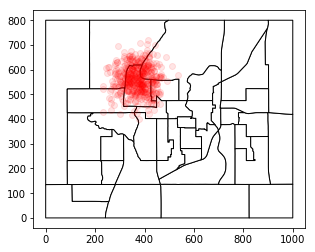

In [20]:
#### Group 1 Retail Locus

n_retail_jobs_1 = int(total_employment * 0.1)

mean = [370, 560,]
cov = [
    [3000, 0], 
    [0, 3000], 
] 
x, y = np.random.multivariate_normal(mean, cov, n_retail_jobs_1).T
retail_locations_1 = pd.DataFrame.from_dict({
    'X':x,
    'Y':y,
})

retail_locations_1 = gpd.GeoDataFrame(
    retail_locations_1, 
    geometry=gpd.points_from_xy(retail_locations_1.X, retail_locations_1.Y),
    crs={},
)
retail_locations_1 = gpd.sjoin(retail_locations_1, taz_shape[['TAZ','geometry']], how='inner', op='within')

ax =taz_shape.plot(edgecolor='k', color='w')
retail_locations_1.plot(ax=ax, color='red', alpha=0.1);

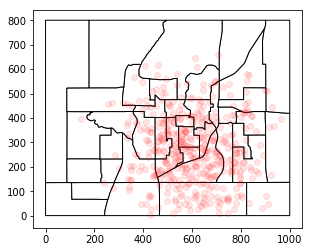

In [21]:
#### Group 2 Retail Background

n_retail_jobs_2 = int(total_employment * 0.1)

mean = [600, 250,]
cov = [
    [22000, 0], 
    [0, 22000], 
] 
x, y = np.random.multivariate_normal(mean, cov, n_retail_jobs_2).T
retail_locations_2 = pd.DataFrame.from_dict({
    'X':x,
    'Y':y,
})

retail_locations_2 = gpd.GeoDataFrame(
    retail_locations_2, 
    geometry=gpd.points_from_xy(retail_locations_2.X, retail_locations_2.Y),
    crs={},
)
retail_locations_2 = gpd.sjoin(retail_locations_2, taz_shape[['TAZ','geometry']], how='inner', op='within')

ax =taz_shape.plot(edgecolor='k', color='w')
retail_locations_2.plot(ax=ax, color='red', alpha=0.1)

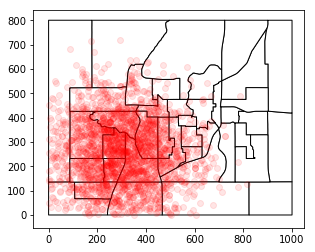

In [22]:
#### Group 3 Downtown Locus

n_other_jobs_1 = int(total_employment * 0.5)

mean = [300, 250,]
cov = [
    [22000, 0], 
    [0, 22000], 
] 
x, y = np.random.multivariate_normal(mean, cov, n_other_jobs_1).T
other_locations_1 = pd.DataFrame.from_dict({
    'X':x,
    'Y':y,
})

other_locations_1 = gpd.GeoDataFrame(
    other_locations_1, 
    geometry=gpd.points_from_xy(other_locations_1.X, other_locations_1.Y),
    crs={},
)
other_locations_1 = gpd.sjoin(other_locations_1, taz_shape[['TAZ','geometry']], how='inner', op='within')

ax =taz_shape.plot(edgecolor='k', color='w')
other_locations_1.plot(ax=ax, color='red', alpha=0.1)

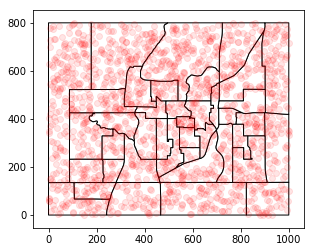

In [23]:
#### Group 4 Background

n_other_jobs_2 = total_employment - len(other_locations_1) - len(retail_locations_2) - len(retail_locations_1)

x2 = np.random.random(n_other_jobs_2)*1000
y2 = np.random.random(n_other_jobs_2)*800
other_locations_2 = pd.DataFrame.from_dict({
    'X':x2,
    'Y':y2,
})
other_locations_2 = gpd.GeoDataFrame(
    other_locations_2, 
    geometry=gpd.points_from_xy(other_locations_2.X, other_locations_2.Y),
    crs={},
)

other_locations_2 = gpd.sjoin(other_locations_2, taz_shape[['TAZ','geometry']], how='inner', op='within')

ax =taz_shape.plot(edgecolor='k', color='w')
other_locations_2.plot(ax=ax, color='red', alpha=0.1);

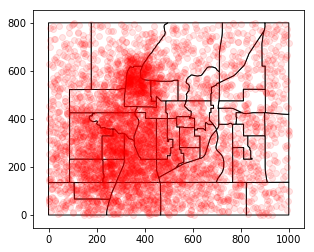

In [24]:
## Merge all employment

retail_locations_1['JOBTYPE'] = 'retail'
retail_locations_2['JOBTYPE'] = 'retail'
other_locations_1['JOBTYPE'] = 'nonretail'
other_locations_2['JOBTYPE'] = 'nonretail'


job_location = pd.concat([retail_locations_1,retail_locations_2,other_locations_1,other_locations_2])

job_location = job_location.reset_index(drop=True)
job_location['JOBTYPE'] = job_location['JOBTYPE'].astype('category')

ax =taz_shape.plot(edgecolor='k', color='w')
job_location.plot(ax=ax, color='red', alpha=0.1);

In [25]:
taz_employment = job_location.groupby(['TAZ','JOBTYPE']).size().unstack().fillna(0).astype(int)
taz_employment.rename({'retail':'RETAIL_EMP', 'nonretail':'NONRETAIL_EMP'}, axis=1, inplace=True)

In [26]:
taz_employment['TOTAL_EMP'] = taz_employment['NONRETAIL_EMP'] + taz_employment['RETAIL_EMP']

In [27]:
taz_employment.columns.name = None

In [28]:
taz_employment.head()

,NONRETAIL_EMP,RETAIL_EMP,TOTAL_EMP
TAZ,,,
1,88,236,324
2,45,6,51
3,118,1,119
4,183,7,190
5,24,8,32


In [29]:
# Save
taz_employment.to_csv(larch.exampville.files.employment)

## Network Graph

In [30]:
from itertools import tee
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)


In [31]:
highway_route = [12,2,10,23,24,26,27,39,11]
transit_line = [39,6,36,25,29,17,31,14,34]

In [32]:
speed_road = 3 # minutes per mile
speed_highway = 1 # minutes per mile
speed_train = 1.2 # minutes per mile
speed_walk = 20 # minutes per mile
speed_bike = 5 # minutes per mile

In [33]:
g = nx.DiGraph()

for index, zone in taz_shape.iterrows():   
    # get 'not disjoint' countries
    neighbors = taz_shape[~taz_shape.geometry.disjoint(zone.geometry)].TAZ.tolist()
    neighborc = taz_shape[~taz_shape.geometry.disjoint(zone.geometry)].geometry.centroid.tolist()

    # add names of neighbors as NEIGHBORS value
    for name, cent in zip(neighbors,neighborc):
        if zone.TAZ != name:
            otaz, dtaz = int(zone.TAZ), int(name)
            distance = (zone.geometry.centroid.distance(cent)) / 100
            if otaz in highway_route and dtaz in highway_route:
                cartime = distance * speed_highway
            else:
                cartime = distance * speed_road
            if otaz in [25,36,3]:
                cartime += 3 # congestion
            if dtaz in [25,36,3]:
                cartime += 5 # congestion
            if otaz in transit_line and dtaz in transit_line:
                transit_ivtt = distance * speed_train
                transit_ovtt = 999999
                transit_time = transit_ivtt
            else:
                transit_ivtt = 999999
                transit_ovtt = distance * speed_walk
                transit_time = transit_ovtt
            g.add_edge(
                otaz, dtaz, 
                distance=distance, cartime=cartime,
                transit_ovtt=transit_ovtt,
                transit_ivtt=transit_ivtt,
                transit_time=transit_time,
            )


In [34]:
taz_shape.index = taz_shape.TAZ

In [35]:
centroids = taz_shape.centroid

/Users/jpn/anaconda/envs/greenhouse/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


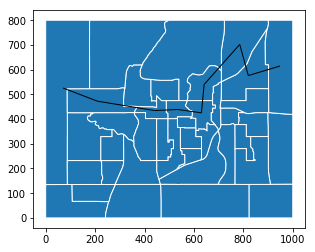

In [36]:
## Highway Map
ax = taz_shape.plot(edgecolor='w')
nx.draw_networkx_edges(    
    g, 
    pos={i:p.coords[0] for i,p in centroids.iteritems()}, 
    ax=ax,
    arrows=False,
    edgelist = list(pairwise(highway_route))
);

/Users/jpn/anaconda/envs/greenhouse/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


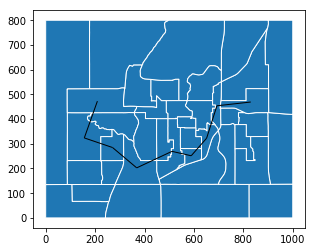

In [37]:
## Transit Map
ax = taz_shape.plot(edgecolor='w')
nx.draw_networkx_edges(    
    g, 
    pos={i:p.coords[0] for i,p in centroids.iteritems()}, 
    ax=ax,
    arrows=False,
    edgelist = list(pairwise(transit_line))
);

In [38]:
# Skim walk times

WALKDIST = np.zeros([40,40])

for otaz in range(1,41):
    shortpaths = nx.shortest_path_length(g, source=otaz, weight='distance')
    for dtaz,t in shortpaths.items():
        WALKDIST[otaz-1,dtaz-1] = t
    # Intrazonal
    WALKDIST[otaz-1,otaz-1] = np.sqrt(taz_shape.loc[otaz,'geometry'].area)/100
    
print(WALKDIST)

[[1.26008879 5.33674896 4.58318093 ... 6.18954756 1.69554975 2.37320583]
 [5.33674896 1.58559083 7.10162147 ... 3.58697088 6.58003239 4.68712856]
 [4.58318093 7.10162147 0.84878748 ... 6.03594579 3.16473549 2.58607677]
 ...
 [6.18954756 3.58697088 6.03594579 ... 1.47478351 7.36821732 4.27530036]
 [1.69554975 6.58003239 3.16473549 ... 7.36821732 1.52806696 3.1778055 ]
 [2.37320583 4.68712856 2.58607677 ... 4.27530036 3.1778055  0.93934102]]


In [39]:
# Skim car times

CARTIME = np.zeros([40,40])
CARDIST = np.zeros([40,40])

for otaz in range(1,41):
    shortpaths = nx.shortest_path(g, source=otaz, weight='cartime')
    for dtaz,pth in shortpaths.items():
        cartime, cardist = 0,0
        for i,j in pairwise(pth):
            cartime += g.edges[i,j]['cartime']
            cardist += g.edges[i,j]['distance']
        CARTIME[otaz-1,dtaz-1] = cartime
        CARDIST[otaz-1,dtaz-1] = cardist
    # Intrazonal
    intrazonal_dist = np.sqrt(taz_shape.loc[otaz,'geometry'].area)/100
    CARTIME[otaz-1,otaz-1] = intrazonal_dist * speed_road
    CARDIST[otaz-1,otaz-1] = intrazonal_dist
    if otaz in [25,36,3]:
        CARTIME[otaz-1,otaz-1] += 5 # congestion
        
print(CARTIME)

[[ 3.78026636  7.55074623 20.03817767 ... 14.84435807  5.08664924
   7.1196175 ]
 [ 7.55074623  4.75677248 21.53156082 ... 10.76091265  6.58003239
   7.46190167]
 [18.03817767 19.53156082  7.54636244 ... 26.82517266 12.95152843
  18.69703682]
 ...
 [14.84435807 10.76091265 28.82517266 ...  4.42435054 13.87364423
  12.82590109]
 [ 5.08664924  6.58003239 14.95152843 ... 13.87364423  4.58420087
   6.14890366]
 [ 7.1196175   7.46190167 20.69703682 ... 12.82590109  6.14890366
   2.81802305]]


In [40]:
## Skim Transit times 

from itertools import tee
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

TRANSIT_IVTT = np.zeros([40,40])
TRANSIT_OVTT = np.zeros([40,40])


for otaz in range(1,41):
    shortpaths = nx.shortest_path(g, source=otaz, weight='transit_time')
    for dtaz,pth in shortpaths.items():
        ivtt, ovtt = 0,0
        for i,j in pairwise(pth):
            if g.edges[i,j]['transit_ivtt'] < 999999:
                ivtt += g.edges[i,j]['transit_ivtt']
            else:
                ovtt += g.edges[i,j]['transit_ovtt']
        if ovtt == 0:
            ovtt = np.sqrt(taz_shape.loc[otaz,'geometry'].area)/150 + np.sqrt(taz_shape.loc[dtaz,'geometry'].area)/150
        TRANSIT_IVTT[otaz-1,dtaz-1] = ivtt
        TRANSIT_OVTT[otaz-1,dtaz-1] = ovtt

In [41]:
print(TRANSIT_IVTT[:5,:5])

[[ 0.         12.16681923  3.34322095  0.         12.16681923]
 [12.16681923  0.          7.28835487  8.82359828  0.        ]
 [ 3.34322095  7.28835487  0.          0.          7.28835487]
 [ 0.          8.82359828  0.          0.          8.82359828]
 [12.16681923  0.          7.28835487  8.82359828  0.        ]]


In [42]:
print(TRANSIT_IVTT[5:10,5:10])

[[ 0.         10.27128369  4.87262088  1.89553554 10.27128369]
 [10.27128369  0.          1.65255376 12.16681923  0.        ]
 [ 4.87262088  1.65255376  0.          0.          0.        ]
 [ 1.89553554 12.16681923  0.          0.          0.        ]
 [10.27128369  0.          0.          0.          0.        ]]


In [43]:
print(TRANSIT_OVTT[:5,:5])

[[ 1.68011838 55.40770608 53.31126782 54.30474188 51.92986575]
 [55.40770608  2.1141211  42.40834339 41.86677092 39.51558199]
 [53.31126782 42.40834339  1.13171664 39.77033266 38.93050306]
 [54.30474188 41.86677092 39.77033266  1.59494151 38.38893059]
 [51.92986575 39.51558199 38.93050306 38.38893059  1.33312576]]


In [44]:
nx.shortest_path(g, source=30, weight='transit_time')[17]

[30, 17]

In [45]:
TRANSIT_OVTT[30-1,17-1]

13.623549779792938

In [46]:
print(TRANSIT_OVTT[5:10,5:10])

[[ 2.13185101 44.79634199 52.86833727 45.94660431 47.64017297]
 [44.79634199  2.23727869 96.67959495 90.7429463  92.43651496]
 [52.86833727 96.67959495  1.28229674 57.83865222 79.11952302]
 [45.94660431 90.7429463  57.83865222  3.35766701 97.40276959]
 [47.64017297 92.43651496 79.11952302 97.40276959  2.30316209]]


In [48]:
if os.path.exists(larch.exampville.files.skims):
    os.remove(larch.exampville.files.skims)

In [49]:
## Assemble Skims into an OMX File
skims_omx = larch.OMX(larch.exampville.files.skims, mode='w')

In [50]:
skims_omx.add_matrix('TRANSIT_IVTT', TRANSIT_IVTT)
skims_omx.add_matrix('TRANSIT_OVTT', TRANSIT_OVTT)
skims_omx.add_matrix('TRANSIT_FARE', (TRANSIT_IVTT>0)*2.50)

skims_omx.add_matrix('WALK_DIST', WALKDIST)
skims_omx.add_matrix('WALK_TIME', WALKDIST * speed_walk)
skims_omx.add_matrix('BIKE_TIME', WALKDIST * speed_bike)

skims_omx.add_matrix('AUTO_TIME', CARTIME)
skims_omx.add_matrix('AUTO_COST', CARDIST * 0.35)
skims_omx.add_matrix('AUTO_DIST', CARDIST);

In [52]:
skims_omx.add_lookup('TAZ_ID', np.arange(nZones)+1);

/lookup/TAZ_ID (CArray(40,), shuffle, zlib(1)) ''
  atom := Int64Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (8192,)

In [53]:
skims_omx.close()

In [55]:
skims_omx = larch.OMX(larch.exampville.files.skims, mode='r')

## Tours

In [56]:
# Tour Modes
DA = 1
SR = 2
Walk = 3
Bike = 4
Transit = 5

In [57]:
## Tours


n_TOUR = PERntours.sum()

TOURid      = np.arange(n_TOUR, dtype=np.int64)
TOURper     = np.zeros(n_TOUR, dtype=np.int64)
TOURperidx  = np.zeros(n_TOUR, dtype=np.int64)
TOURhh      = np.zeros(n_TOUR, dtype=np.int64)
TOURhhidx   = np.zeros(n_TOUR, dtype=np.int64)
TOURdtaz    = np.zeros(n_TOUR, dtype=np.int64)
TOURmode    = np.zeros(n_TOUR, dtype=np.int64)
TOURpurpose = np.zeros(n_TOUR, dtype=np.int64)

# Work tours, then other tours
n2 = 0
for n1 in range(n_PER):
    TOURper[n2:(n2 + PERntours[n1])] = PERid[n1]
    TOURperidx[n2:(n2 + PERntours[n1])] = PERidx[n1]
    TOURhh[n2:(n2 + PERntours[n1])] = PERhhid[n1]
    TOURhhidx[n2:(n2 + PERntours[n1])] = PERhhidx[n1]
    TOURpurpose[n2:(n2 + PERnworktours[n1])] = 1
    TOURpurpose[(n2 + PERnworktours[n1]):(n2 + PERntours[n1])] = 2
    n2 += PERntours[n1]

In [58]:
#### Utility by mode to various destinations
nameModes = ['DA', 'SR', 'Walk', 'Bike', 'Transit']
mDA = 0
mSR = 1
mWA = 2
mBI = 3
mTR = 4
nModes = len(nameModes)

nModeNests = 3

paramCOST = -0.312
paramTIME = -0.123
paramNMTIME = -0.246
paramDIST = -0.00357
paramLNDIST = -0.00642

paramMUcar = 0.5
paramMUnon = 0.75
paramMUmot = 0.8
paramMUtop = 1.0

In [59]:
zone_retail = taz_employment.RETAIL_EMP
zone_nonretail =  taz_employment.NONRETAIL_EMP

In [60]:
Util = np.zeros([n_TOUR, nZones, nModes])
for n in range(n_TOUR):
    # Mode
    otazi = HH.HOMETAZ[TOURhhidx[n]] - 1
    Util[n, :, mDA] += (
        + skims_omx.AUTO_TIME[otazi, :] * paramTIME 
        + skims_omx.AUTO_COST[otazi, :] * paramCOST
    )
    if HH.INCOME[TOURhhidx[n]] >= 75000:
        Util[n, :, mDA] += 1.0
        Util[n, :, mTR] -= 0.5
    Util[n, :, mSR] += (
        + skims_omx.AUTO_TIME[otazi, :] * paramTIME 
        - 1.0 
        + skims_omx.AUTO_COST[otazi, :] * paramCOST * 0.5
    )
    Util[n, :, mWA] += 3.0 + skims_omx.WALK_TIME[otazi, :] * paramNMTIME
    Util[n, :, mBI] += -2.25 + skims_omx.BIKE_TIME[otazi, :] * paramNMTIME
    Util[n, :, mTR] += (
        + 1.5 
        + skims_omx.TRANSIT_IVTT[otazi, :] * paramTIME 
        + skims_omx.TRANSIT_OVTT[otazi, :] * paramTIME * 2.2
        + skims_omx.TRANSIT_FARE[otazi, :] * paramCOST
    )
    
    # Destination
    Util[n, :, :] += skims_omx.AUTO_DIST[:][otazi, :, None] * paramDIST + np.log1p(skims_omx.AUTO_DIST[:][otazi, :, None]) * paramLNDIST
    if HH.INCOME[TOURhhidx[n]] <= 50000:
        Util[n, :, :] += 0.75 * np.log(zone_retail * 2.71828 + zone_nonretail)[:, None]
    else:
        Util[n, :, :] += 0.75 * np.log(zone_retail + zone_nonretail * 2.71828)[:, None]
    # flog('Util[n,:,:]  ...')
    #		flog('{}',Util[n,:,:])
    # Unavails
    if PERage[TOURperidx[n]] < 16:
        Util[n, :, mDA] = -np.inf
    Util[n, skims_omx.TRANSIT_FARE[otazi, :] <= 0, mTR] = -np.inf
    Util[n, skims_omx.WALK_TIME[otazi, :] >= 60, mWA] = -np.inf
    Util[n, skims_omx.BIKE_TIME[otazi, :] >= 60, mBI] = -np.inf

    

In [61]:
from numpy import log, exp

In [62]:
CPr_car = np.zeros([n_TOUR, nZones, 2])  # [DA,SR]
CPr_non = np.zeros([n_TOUR, nZones, 2])  # [WA,BI]
CPr_mot = np.zeros([n_TOUR, nZones, 2])  # [TR,Car]
CPr_top = np.zeros([n_TOUR, nZones, 2])  # [Non,Mot]

NLS_car = np.zeros([n_TOUR, nZones, ])
NLS_non = np.zeros([n_TOUR, nZones, ])
NLS_mot = np.zeros([n_TOUR, nZones, ])
MLS_top = np.zeros([n_TOUR, nZones, ])  # Mode choice logsum
DLS_top = np.zeros([n_TOUR, ])  # Dest choice logsum

Pr_modes = np.zeros([n_TOUR, nZones, nModes])
Pr_dest = np.zeros([n_TOUR, nZones])

with np.errstate(divide='ignore', invalid='ignore'):
    for n in range(n_TOUR):
        NLS_car[n, :] = paramMUcar * log(np.exp(Util[n, :, mDA] / paramMUcar) + exp(Util[n, :, mSR] / paramMUcar))
        NLS_non[n, :] = paramMUnon * log(np.exp(Util[n, :, mWA] / paramMUnon) + exp(Util[n, :, mBI] / paramMUnon))
        NLS_mot[n, :] = paramMUmot * log(np.exp(NLS_car[n, :] / paramMUmot) + exp(Util[n, :, mTR] / paramMUmot))
        MLS_top[n, :] = log(exp(NLS_non[n, :]) + exp(NLS_mot[n, :]))
        DLS_top[n] = log(np.sum(exp(MLS_top[n, :])))

        Pr_dest[n, :] = exp(MLS_top[n, :] - DLS_top[n])

        CPr_top[n, :, 0] = exp((NLS_non[n, :] - MLS_top[n, :]) / paramMUtop)
        CPr_top[n, :, 1] = exp((NLS_mot[n, :] - MLS_top[n, :]) / paramMUtop)
        CPr_mot[n, :, 0] = exp((Util[n, :, mTR] - NLS_mot[n, :]) / paramMUmot)
        CPr_mot[n, :, 1] = exp((NLS_car[n, :] - NLS_mot[n, :]) / paramMUmot)
        CPr_non[n, :, 0] = exp((Util[n, :, mWA] - NLS_non[n, :]) / paramMUnon)
        CPr_non[n, :, 1] = exp((Util[n, :, mBI] - NLS_non[n, :]) / paramMUnon)
        CPr_car[n, :, 0] = exp((Util[n, :, mDA] - NLS_car[n, :]) / paramMUcar)
        CPr_car[n, :, 1] = exp((Util[n, :, mSR] - NLS_car[n, :]) / paramMUcar)

        Pr_modes[n, :, mTR] = CPr_mot[n, :, 0] * CPr_top[n, :, 1] * Pr_dest[n, :]
        Pr_modes[n, :, mWA] = CPr_non[n, :, 0] * CPr_top[n, :, 0] * Pr_dest[n, :]
        Pr_modes[n, :, mBI] = CPr_non[n, :, 1] * CPr_top[n, :, 0] * Pr_dest[n, :]
        Pr_modes[n, :, mDA] = CPr_car[n, :, 0] * CPr_mot[n, :, 1] * CPr_top[n, :, 1] * Pr_dest[n, :]
        Pr_modes[n, :, mSR] = CPr_car[n, :, 1] * CPr_mot[n, :, 1] * CPr_top[n, :, 1] * Pr_dest[n, :]

Pr_modes[np.isnan(Pr_modes)] = 0

In [63]:
## Choices
for n in range(n_TOUR):
    try:
        ch = np.random.choice(nModes * nZones, replace=True, p=Pr_modes[n, :, :].ravel())
    except:
        print("total prob = {}", Pr_modes[n, :, :].sum())
        raise
    dtazi = ch // nModes
    modei = ch - (dtazi * nModes)
    TOURdtaz[n] = dtazi + 1
    TOURmode[n] = modei + 1

In [64]:
f_tour = pd.DataFrame.from_dict(
    dict([
        ('TOURID', TOURid),
        ('HHID', TOURhh),
        ('PERSONID', TOURper),
        ('DTAZ', TOURdtaz),
        ('TOURMODE', TOURmode),
        ('TOURPURP', TOURpurpose),
    ])
)
# f_tour_filename = os.path.join(directory, 'exampville_tours.csv')
# f_tour.to_csv(f_tour_filename)


In [65]:
f_tour.set_index('TOURID', inplace=True)

In [67]:
f_tour.to_csv(larch.exampville.files.tour)

In [68]:
DA = 1
SR = 2
Walk = 3
Bike = 4
Transit = 5

In [69]:
dfs = larch.DataFrames(
    co=f_tour, 
    alt_codes=[DA,SR,Walk,Bike,Transit], 
    alt_names=['DA','SR','Walk','Bike','Transit'],
    ch_name='TOURMODE',
)

In [70]:
dfs.data_ch

,1,2,3,4,5
TOURID,,,,,
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0
7,0.0,1.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0


In [71]:
dfs.choice_avail_summary()

,name,chosen,available,chosen but not available
1,DA,11495.0,None,11495.0
2,SR,2954.0,None,2954.0
3,Walk,469.0,None,469.0
4,Bike,180.0,None,180.0
5,Transit,836.0,None,836.0
< Total All Alternatives >,,15934.0,,15934.0
